[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1t0_4BxEJ0XncyYvn_VyEQhxwNMvtSUNx?usp=sharing)

In [1]:
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
from copy import deepcopy
from pathlib import Path
from gsat import GSAT, ExtractorMLP
from utils import get_data_loaders, get_model, set_seed, Criterion, init_metric_dict, load_checkpoint
from trainer import run_one_epoch, update_best_epoch_res, get_viz_idx, visualize_results
from datetime import datetime


In [2]:
# dataset_name = 'ba_2motifs'
# dataset_name = 'mutag'
# model_name = 'GIN'

dataset_name = 'ogbg_molhiv'
model_name = 'PNA'

method_name = 'GSAT'
cuda_id = 0
seed = 0
set_seed(seed)

In [3]:
data_dir = Path('../data')
device = torch.device(f'cuda:{cuda_id}' if cuda_id >= 0 else 'cpu')

if model_name == 'GIN':
    model_config = {'model_name': 'GIN', 'hidden_size': 64, 'n_layers': 2, 'dropout_p': 0.3, 'use_edge_attr': True}
else:
    assert model_name == 'PNA'
    model_config = {'model_name': 'PNA', 'hidden_size': 80, 'n_layers': 4, 'dropout_p': 0.3, 'use_edge_attr': False, 
                    'atom_encoder': True, 'aggregators': ['mean', 'min', 'max', 'std'], 'scalers': False}
    
metric_dict = deepcopy(init_metric_dict)
model_dir = data_dir / dataset_name / 'logs' / (datetime.now().strftime("%m_%d_%Y-%H_%M_%S") + '-' + dataset_name + '-' + model_name + '-seed' + str(seed) + '-' + method_name)


In [4]:
loaders, test_set, x_dim, edge_attr_dim, num_class, aux_info = get_data_loaders(data_dir, dataset_name, batch_size=128, random_state=seed,
                                                                                splits={'train': 0.8, 'valid': 0.1, 'test': 0.1}, 
                                                                                mutag_x=True if dataset_name == 'mutag' else False)
model_config['deg'] = aux_info['deg']

[INFO] Using default splits!


/home/oyxy2019/.conda/envs/oyxy01/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/oyxy2019/.conda/envs/oyxy01/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDa

[INFO] Calculating degree...


In [5]:
clf = get_model(x_dim, edge_attr_dim, num_class, aux_info['multi_label'], model_config, device)
extractor = ExtractorMLP(model_config['hidden_size'], learn_edge_att=False).to(device)
optimizer = torch.optim.Adam(list(extractor.parameters()) + list(clf.parameters()), lr=1e-3, weight_decay=3.0e-6)
criterion = Criterion(num_class, aux_info['multi_label'])
gsat = GSAT(clf, extractor, criterion, optimizer, learn_edge_att=False, final_r=0.7)

[INFO] Using multi_label: False


In [6]:
for epoch in range(100):
    train_res = run_one_epoch(gsat, loaders['train'], epoch, 'train', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    valid_res = run_one_epoch(gsat, loaders['valid'], epoch, 'valid', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    test_res = run_one_epoch(gsat, loaders['test'], epoch, 'test', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    
    metric_dict = update_best_epoch_res(gsat, train_res, valid_res, test_res, metric_dict, dataset_name, epoch, model_dir)
    print(f'[Seed {seed}, Epoch: {epoch}]: Best Epoch: {metric_dict["metric/best_clf_epoch"]}, '
          f'Best Val Pred ACC/ROC: {metric_dict["metric/best_clf_valid"]:.3f}, Best Test Pred ACC/ROC: {metric_dict["metric/best_clf_test"]:.3f}, '
          f'Best Test X AUROC: {metric_dict["metric/best_x_roc_test"]:.3f}')
    print('='*50)
    print('='*50)

[Seed 0, Epoch: 0]: gsat_train finished, loss: 0.372, pred: 0.184, info: 0.189, clf_acc: 0.958, clf_roc: 0.593, att_roc: 0.000: 100%|██████████| 258/258 [00:15<00:00, 16.61it/s]
[Seed 0, Epoch: 0]: gsat_valid finished, loss: 0.145, pred: 0.093, info: 0.052, clf_acc: 0.980, clf_roc: 0.743, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 35.86it/s]
[Seed 0, Epoch: 0]: gsat_test  finished, loss: 0.180, pred: 0.127, info: 0.053, clf_acc: 0.968, clf_roc: 0.718, att_roc: 0.000: 100%|██████████| 33/33 [00:01<00:00, 32.80it/s]


[Seed 0, Epoch: 0]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 1]: gsat_train finished, loss: 0.238, pred: 0.150, info: 0.088, clf_acc: 0.963, clf_roc: 0.698, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.99it/s]
[Seed 0, Epoch: 1]: gsat_valid finished, loss: 0.185, pred: 0.114, info: 0.071, clf_acc: 0.980, clf_roc: 0.747, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 56.52it/s]
[Seed 0, Epoch: 1]: gsat_test  finished, loss: 0.212, pred: 0.141, info: 0.071, clf_acc: 0.968, clf_roc: 0.744, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 61.09it/s]


[Seed 0, Epoch: 1]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 2]: gsat_train finished, loss: 0.227, pred: 0.142, info: 0.086, clf_acc: 0.963, clf_roc: 0.737, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.49it/s]
[Seed 0, Epoch: 2]: gsat_valid finished, loss: 0.157, pred: 0.080, info: 0.077, clf_acc: 0.980, clf_roc: 0.765, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.64it/s]
[Seed 0, Epoch: 2]: gsat_test  finished, loss: 0.195, pred: 0.118, info: 0.077, clf_acc: 0.968, clf_roc: 0.738, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 42.35it/s]


[Seed 0, Epoch: 2]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 3]: gsat_train finished, loss: 0.222, pred: 0.137, info: 0.085, clf_acc: 0.963, clf_roc: 0.761, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.67it/s]
[Seed 0, Epoch: 3]: gsat_valid finished, loss: 0.158, pred: 0.079, info: 0.078, clf_acc: 0.980, clf_roc: 0.777, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 45.79it/s]
[Seed 0, Epoch: 3]: gsat_test  finished, loss: 0.201, pred: 0.122, info: 0.079, clf_acc: 0.968, clf_roc: 0.748, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 57.16it/s]


[Seed 0, Epoch: 3]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 4]: gsat_train finished, loss: 0.219, pred: 0.134, info: 0.085, clf_acc: 0.963, clf_roc: 0.769, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.66it/s]
[Seed 0, Epoch: 4]: gsat_valid finished, loss: 0.160, pred: 0.081, info: 0.079, clf_acc: 0.980, clf_roc: 0.782, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 56.71it/s]
[Seed 0, Epoch: 4]: gsat_test  finished, loss: 0.200, pred: 0.121, info: 0.079, clf_acc: 0.968, clf_roc: 0.750, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 49.98it/s]


[Seed 0, Epoch: 4]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 5]: gsat_train finished, loss: 0.216, pred: 0.131, info: 0.085, clf_acc: 0.962, clf_roc: 0.784, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.50it/s]
[Seed 0, Epoch: 5]: gsat_valid finished, loss: 0.158, pred: 0.080, info: 0.078, clf_acc: 0.980, clf_roc: 0.801, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.30it/s]
[Seed 0, Epoch: 5]: gsat_test  finished, loss: 0.197, pred: 0.119, info: 0.078, clf_acc: 0.968, clf_roc: 0.759, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.50it/s]


[Seed 0, Epoch: 5]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 6]: gsat_train finished, loss: 0.213, pred: 0.128, info: 0.085, clf_acc: 0.962, clf_roc: 0.790, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.33it/s]
[Seed 0, Epoch: 6]: gsat_valid finished, loss: 0.155, pred: 0.077, info: 0.078, clf_acc: 0.982, clf_roc: 0.788, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.08it/s]
[Seed 0, Epoch: 6]: gsat_test  finished, loss: 0.195, pred: 0.117, info: 0.078, clf_acc: 0.968, clf_roc: 0.762, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.94it/s]


[Seed 0, Epoch: 6]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 7]: gsat_train finished, loss: 0.212, pred: 0.128, info: 0.085, clf_acc: 0.963, clf_roc: 0.793, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 21.04it/s]
[Seed 0, Epoch: 7]: gsat_valid finished, loss: 0.157, pred: 0.079, info: 0.078, clf_acc: 0.982, clf_roc: 0.792, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.79it/s]
[Seed 0, Epoch: 7]: gsat_test  finished, loss: 0.195, pred: 0.117, info: 0.078, clf_acc: 0.968, clf_roc: 0.778, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 57.56it/s]


[Seed 0, Epoch: 7]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 8]: gsat_train finished, loss: 0.209, pred: 0.125, info: 0.084, clf_acc: 0.964, clf_roc: 0.797, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.85it/s]
[Seed 0, Epoch: 8]: gsat_valid finished, loss: 0.155, pred: 0.077, info: 0.078, clf_acc: 0.982, clf_roc: 0.799, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.62it/s]
[Seed 0, Epoch: 8]: gsat_test  finished, loss: 0.193, pred: 0.115, info: 0.078, clf_acc: 0.970, clf_roc: 0.766, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.29it/s]


[Seed 0, Epoch: 8]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 9]: gsat_train finished, loss: 0.208, pred: 0.124, info: 0.084, clf_acc: 0.964, clf_roc: 0.798, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.73it/s]
[Seed 0, Epoch: 9]: gsat_valid finished, loss: 0.153, pred: 0.075, info: 0.078, clf_acc: 0.982, clf_roc: 0.789, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.05it/s]
[Seed 0, Epoch: 9]: gsat_test  finished, loss: 0.195, pred: 0.117, info: 0.078, clf_acc: 0.968, clf_roc: 0.780, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.90it/s]


[Seed 0, Epoch: 9]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 10]: gsat_train finished, loss: 0.268, pred: 0.126, info: 0.142, clf_acc: 0.964, clf_roc: 0.795, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.37it/s]
[Seed 0, Epoch: 10]: gsat_valid finished, loss: 0.171, pred: 0.074, info: 0.096, clf_acc: 0.982, clf_roc: 0.800, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.40it/s]
[Seed 0, Epoch: 10]: gsat_test  finished, loss: 0.210, pred: 0.114, info: 0.096, clf_acc: 0.968, clf_roc: 0.796, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.70it/s]


[Seed 0, Epoch: 10]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 11]: gsat_train finished, loss: 0.262, pred: 0.125, info: 0.137, clf_acc: 0.964, clf_roc: 0.801, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.82it/s]
[Seed 0, Epoch: 11]: gsat_valid finished, loss: 0.168, pred: 0.073, info: 0.095, clf_acc: 0.981, clf_roc: 0.809, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 49.12it/s]
[Seed 0, Epoch: 11]: gsat_test  finished, loss: 0.218, pred: 0.123, info: 0.095, clf_acc: 0.968, clf_roc: 0.765, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.26it/s]


[Seed 0, Epoch: 11]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 12]: gsat_train finished, loss: 0.258, pred: 0.122, info: 0.136, clf_acc: 0.965, clf_roc: 0.809, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.54it/s]
[Seed 0, Epoch: 12]: gsat_valid finished, loss: 0.178, pred: 0.084, info: 0.094, clf_acc: 0.979, clf_roc: 0.791, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.39it/s]
[Seed 0, Epoch: 12]: gsat_test  finished, loss: 0.214, pred: 0.120, info: 0.094, clf_acc: 0.966, clf_roc: 0.787, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.84it/s]


[Seed 0, Epoch: 12]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 13]: gsat_train finished, loss: 0.259, pred: 0.122, info: 0.136, clf_acc: 0.965, clf_roc: 0.806, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.45it/s]
[Seed 0, Epoch: 13]: gsat_valid finished, loss: 0.166, pred: 0.075, info: 0.091, clf_acc: 0.982, clf_roc: 0.820, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.05it/s]
[Seed 0, Epoch: 13]: gsat_test  finished, loss: 0.214, pred: 0.123, info: 0.091, clf_acc: 0.968, clf_roc: 0.794, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 64.15it/s]


[Seed 0, Epoch: 13]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 14]: gsat_train finished, loss: 0.259, pred: 0.124, info: 0.136, clf_acc: 0.965, clf_roc: 0.817, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.57it/s]
[Seed 0, Epoch: 14]: gsat_valid finished, loss: 0.163, pred: 0.072, info: 0.091, clf_acc: 0.981, clf_roc: 0.815, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.34it/s]
[Seed 0, Epoch: 14]: gsat_test  finished, loss: 0.209, pred: 0.118, info: 0.091, clf_acc: 0.968, clf_roc: 0.782, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 63.23it/s]


[Seed 0, Epoch: 14]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 15]: gsat_train finished, loss: 0.260, pred: 0.124, info: 0.136, clf_acc: 0.965, clf_roc: 0.806, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.53it/s]
[Seed 0, Epoch: 15]: gsat_valid finished, loss: 0.163, pred: 0.069, info: 0.094, clf_acc: 0.982, clf_roc: 0.808, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 63.39it/s]
[Seed 0, Epoch: 15]: gsat_test  finished, loss: 0.204, pred: 0.111, info: 0.093, clf_acc: 0.971, clf_roc: 0.793, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 49.69it/s]


[Seed 0, Epoch: 15]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 16]: gsat_train finished, loss: 0.254, pred: 0.119, info: 0.135, clf_acc: 0.966, clf_roc: 0.817, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 21.04it/s]
[Seed 0, Epoch: 16]: gsat_valid finished, loss: 0.162, pred: 0.070, info: 0.092, clf_acc: 0.982, clf_roc: 0.817, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 57.08it/s]
[Seed 0, Epoch: 16]: gsat_test  finished, loss: 0.207, pred: 0.115, info: 0.092, clf_acc: 0.971, clf_roc: 0.781, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 47.36it/s]


[Seed 0, Epoch: 16]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 17]: gsat_train finished, loss: 0.255, pred: 0.120, info: 0.135, clf_acc: 0.965, clf_roc: 0.812, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.98it/s]
[Seed 0, Epoch: 17]: gsat_valid finished, loss: 0.163, pred: 0.072, info: 0.091, clf_acc: 0.982, clf_roc: 0.834, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.03it/s]
[Seed 0, Epoch: 17]: gsat_test  finished, loss: 0.212, pred: 0.121, info: 0.091, clf_acc: 0.969, clf_roc: 0.783, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.40it/s]


[Seed 0, Epoch: 17]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 18]: gsat_train finished, loss: 0.252, pred: 0.117, info: 0.135, clf_acc: 0.966, clf_roc: 0.826, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.69it/s]
[Seed 0, Epoch: 18]: gsat_valid finished, loss: 0.161, pred: 0.070, info: 0.091, clf_acc: 0.982, clf_roc: 0.822, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.80it/s]
[Seed 0, Epoch: 18]: gsat_test  finished, loss: 0.202, pred: 0.111, info: 0.091, clf_acc: 0.971, clf_roc: 0.793, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 76.79it/s]


[Seed 0, Epoch: 18]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 19]: gsat_train finished, loss: 0.250, pred: 0.116, info: 0.134, clf_acc: 0.966, clf_roc: 0.827, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.18it/s]
[Seed 0, Epoch: 19]: gsat_valid finished, loss: 0.167, pred: 0.073, info: 0.094, clf_acc: 0.981, clf_roc: 0.814, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 61.71it/s]
[Seed 0, Epoch: 19]: gsat_test  finished, loss: 0.212, pred: 0.118, info: 0.094, clf_acc: 0.968, clf_roc: 0.795, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 63.82it/s]


[Seed 0, Epoch: 19]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 20]: gsat_train finished, loss: 0.293, pred: 0.123, info: 0.170, clf_acc: 0.965, clf_roc: 0.804, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.05it/s]
[Seed 0, Epoch: 20]: gsat_valid finished, loss: 0.144, pred: 0.073, info: 0.071, clf_acc: 0.982, clf_roc: 0.808, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.84it/s]
[Seed 0, Epoch: 20]: gsat_test  finished, loss: 0.198, pred: 0.127, info: 0.071, clf_acc: 0.969, clf_roc: 0.794, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.28it/s]


[Seed 0, Epoch: 20]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.808, Best Test Pred ACC/ROC: 0.794, Best Test X AUROC: 0.000


[Seed 0, Epoch: 21]: gsat_train finished, loss: 0.290, pred: 0.122, info: 0.168, clf_acc: 0.966, clf_roc: 0.804, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 21.19it/s]
[Seed 0, Epoch: 21]: gsat_valid finished, loss: 0.132, pred: 0.072, info: 0.060, clf_acc: 0.981, clf_roc: 0.820, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.62it/s]
[Seed 0, Epoch: 21]: gsat_test  finished, loss: 0.182, pred: 0.122, info: 0.060, clf_acc: 0.969, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.79it/s]


[Seed 0, Epoch: 21]: Best Epoch: 21, Best Val Pred ACC/ROC: 0.820, Best Test Pred ACC/ROC: 0.803, Best Test X AUROC: 0.000


[Seed 0, Epoch: 22]: gsat_train finished, loss: 0.287, pred: 0.119, info: 0.168, clf_acc: 0.966, clf_roc: 0.819, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.36it/s]
[Seed 0, Epoch: 22]: gsat_valid finished, loss: 0.152, pred: 0.073, info: 0.079, clf_acc: 0.982, clf_roc: 0.805, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.89it/s]
[Seed 0, Epoch: 22]: gsat_test  finished, loss: 0.193, pred: 0.115, info: 0.079, clf_acc: 0.970, clf_roc: 0.791, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 56.02it/s]


[Seed 0, Epoch: 22]: Best Epoch: 21, Best Val Pred ACC/ROC: 0.820, Best Test Pred ACC/ROC: 0.803, Best Test X AUROC: 0.000


[Seed 0, Epoch: 23]: gsat_train finished, loss: 0.289, pred: 0.121, info: 0.168, clf_acc: 0.965, clf_roc: 0.825, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 21.24it/s]
[Seed 0, Epoch: 23]: gsat_valid finished, loss: 0.143, pred: 0.074, info: 0.068, clf_acc: 0.981, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 57.47it/s]
[Seed 0, Epoch: 23]: gsat_test  finished, loss: 0.183, pred: 0.115, info: 0.068, clf_acc: 0.969, clf_roc: 0.796, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.84it/s]


[Seed 0, Epoch: 23]: Best Epoch: 21, Best Val Pred ACC/ROC: 0.820, Best Test Pred ACC/ROC: 0.803, Best Test X AUROC: 0.000


[Seed 0, Epoch: 24]: gsat_train finished, loss: 0.288, pred: 0.120, info: 0.168, clf_acc: 0.966, clf_roc: 0.812, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 21.24it/s]
[Seed 0, Epoch: 24]: gsat_valid finished, loss: 0.128, pred: 0.071, info: 0.057, clf_acc: 0.982, clf_roc: 0.819, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.44it/s]
[Seed 0, Epoch: 24]: gsat_test  finished, loss: 0.171, pred: 0.114, info: 0.057, clf_acc: 0.970, clf_roc: 0.797, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 61.15it/s]


[Seed 0, Epoch: 24]: Best Epoch: 21, Best Val Pred ACC/ROC: 0.820, Best Test Pred ACC/ROC: 0.803, Best Test X AUROC: 0.000


[Seed 0, Epoch: 25]: gsat_train finished, loss: 0.287, pred: 0.119, info: 0.168, clf_acc: 0.966, clf_roc: 0.816, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 21.35it/s]
[Seed 0, Epoch: 25]: gsat_valid finished, loss: 0.141, pred: 0.069, info: 0.072, clf_acc: 0.983, clf_roc: 0.801, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 67.76it/s]
[Seed 0, Epoch: 25]: gsat_test  finished, loss: 0.183, pred: 0.110, info: 0.072, clf_acc: 0.970, clf_roc: 0.800, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 57.79it/s]


[Seed 0, Epoch: 25]: Best Epoch: 21, Best Val Pred ACC/ROC: 0.820, Best Test Pred ACC/ROC: 0.803, Best Test X AUROC: 0.000


[Seed 0, Epoch: 26]: gsat_train finished, loss: 0.285, pred: 0.117, info: 0.168, clf_acc: 0.966, clf_roc: 0.827, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.89it/s]
[Seed 0, Epoch: 26]: gsat_valid finished, loss: 0.140, pred: 0.071, info: 0.068, clf_acc: 0.981, clf_roc: 0.811, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.60it/s]
[Seed 0, Epoch: 26]: gsat_test  finished, loss: 0.183, pred: 0.115, info: 0.068, clf_acc: 0.969, clf_roc: 0.802, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.23it/s]


[Seed 0, Epoch: 26]: Best Epoch: 21, Best Val Pred ACC/ROC: 0.820, Best Test Pred ACC/ROC: 0.803, Best Test X AUROC: 0.000


[Seed 0, Epoch: 27]: gsat_train finished, loss: 0.286, pred: 0.118, info: 0.168, clf_acc: 0.967, clf_roc: 0.819, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.10it/s]
[Seed 0, Epoch: 27]: gsat_valid finished, loss: 0.147, pred: 0.075, info: 0.072, clf_acc: 0.982, clf_roc: 0.806, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.16it/s]
[Seed 0, Epoch: 27]: gsat_test  finished, loss: 0.184, pred: 0.112, info: 0.072, clf_acc: 0.969, clf_roc: 0.812, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.51it/s]


[Seed 0, Epoch: 27]: Best Epoch: 21, Best Val Pred ACC/ROC: 0.820, Best Test Pred ACC/ROC: 0.803, Best Test X AUROC: 0.000


[Seed 0, Epoch: 28]: gsat_train finished, loss: 0.286, pred: 0.119, info: 0.167, clf_acc: 0.966, clf_roc: 0.816, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.24it/s]
[Seed 0, Epoch: 28]: gsat_valid finished, loss: 0.129, pred: 0.074, info: 0.056, clf_acc: 0.981, clf_roc: 0.813, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 56.12it/s]
[Seed 0, Epoch: 28]: gsat_test  finished, loss: 0.175, pred: 0.119, info: 0.056, clf_acc: 0.968, clf_roc: 0.781, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 57.16it/s]


[Seed 0, Epoch: 28]: Best Epoch: 21, Best Val Pred ACC/ROC: 0.820, Best Test Pred ACC/ROC: 0.803, Best Test X AUROC: 0.000


[Seed 0, Epoch: 29]: gsat_train finished, loss: 0.284, pred: 0.116, info: 0.168, clf_acc: 0.966, clf_roc: 0.833, att_roc: 0.000: 100%|██████████| 258/258 [00:12<00:00, 20.27it/s]
[Seed 0, Epoch: 29]: gsat_valid finished, loss: 0.145, pred: 0.069, info: 0.076, clf_acc: 0.983, clf_roc: 0.814, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.87it/s]
[Seed 0, Epoch: 29]: gsat_test  finished, loss: 0.185, pred: 0.109, info: 0.076, clf_acc: 0.970, clf_roc: 0.818, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 61.53it/s]


[Seed 0, Epoch: 29]: Best Epoch: 21, Best Val Pred ACC/ROC: 0.820, Best Test Pred ACC/ROC: 0.803, Best Test X AUROC: 0.000


[Seed 0, Epoch: 30]: gsat_train........., loss: 0.381, pred: 0.217, info: 0.164, clf_acc: 0.945:  70%|██████▉   | 180/258 [00:09<00:03, 19.89it/s]


KeyboardInterrupt: 

In [7]:
best_epoch = metric_dict['metric/best_clf_epoch']
load_checkpoint(gsat, model_dir, model_name=f'gsat_epoch_{best_epoch}', map_location=device)

100%|██████████| 10/10 [00:00<00:00, 23.53it/s]


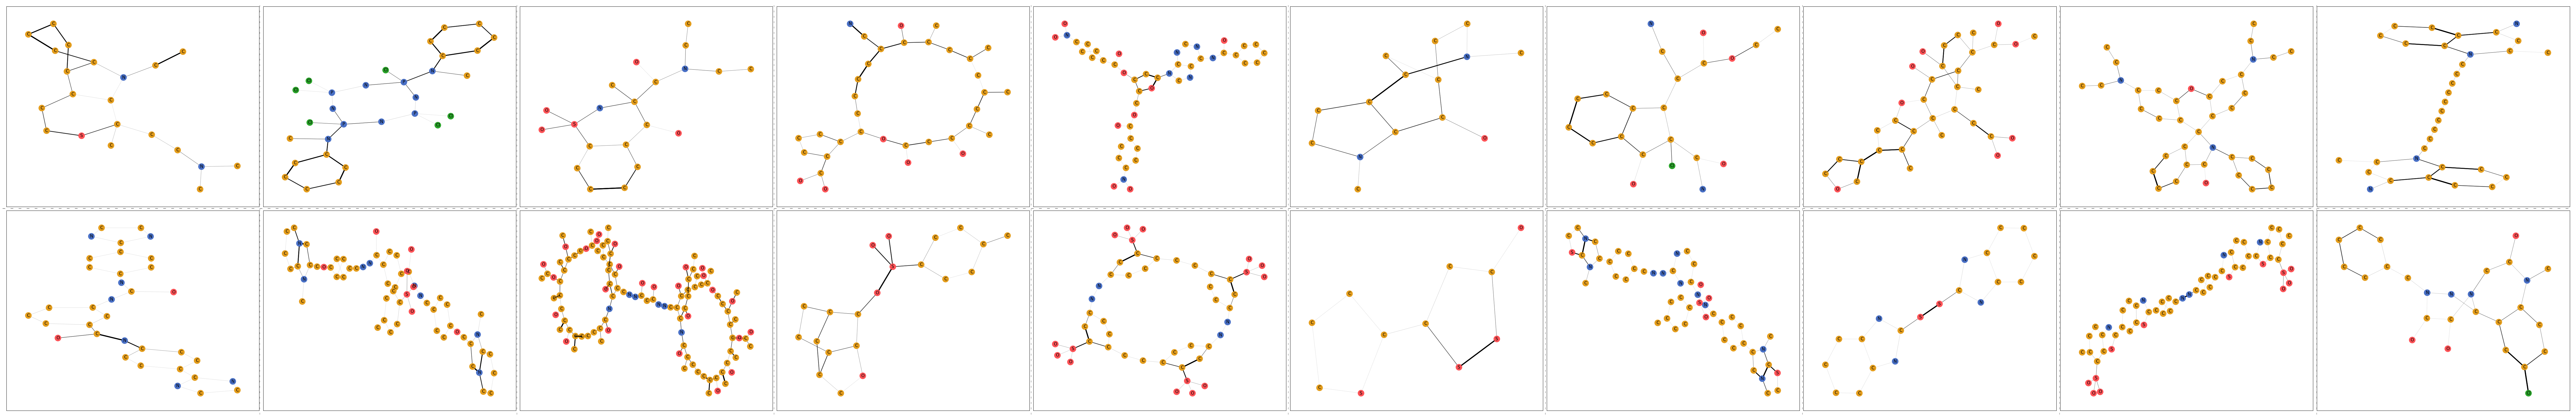

In [10]:
num_viz_samples = 10
assert aux_info['multi_label'] is False

all_viz_set = get_viz_idx(test_set, dataset_name, num_viz_samples)
visualize_results(gsat, all_viz_set, test_set, num_viz_samples, dataset_name, model_config['use_edge_attr'])